In [72]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
from queue import Queue
from collections import deque
from scipy.stats import norm
from itertools import accumulate
import numpy.polynomial.polynomial as poly

from utils import parse_date,determine_R0,return_polyfit,decay_to_max,unwrap_projections
from generators import advanced_projector,infection_projector

%matplotlib inline
plt.style.use('fivethirtyeight')

# Plotting functions

In [52]:
def plot_totals(cases,deaths=None):
    epochs = range(1,len(cases)+1)
    _, ax = plt.subplots()
    ax.plot(epochs,cases,'g',label="Confirmed Cases")
    if deaths:
        ax.plot(epochs,deaths,'m',label="Deaths")
    ax.set_title('Covid19')
    ax.set_xlabel('Days')
    ax.set_ylabel('Cases')
    ax.legend()
    plt.show()
    # plt.savefig('assets/Covid19',bbox_inches='tight')
    # plt.close()
    
def detailed_plot(values,labels,show=False):
    colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
    for i,label in enumerate(labels):
        epochs = range(1,len(values[label])+1)
        plt.plot(epochs,values[label],colors[i],label=f"{label}")
        plt.title('Covid19')
        plt.xlabel('Days')
        plt.ylabel('Cases')
        plt.legend()
    if show:
        plt.show()

# Data paths

Data gathered by download_datasets.sh

In [4]:
general_path = 'novel-corona-virus-2019-dataset'
korea_path = 'coronavirusdataset'
USA_path = 'covid19-in-usa'
Italy_path = 'covid19-in-italy'
coronavirusapi_States_path = 'states.csv'
coronavirusapi_USA_path = 'time_series.csv'
covidtracking_States_path = 'states_daily.csv'
covidtracking_USA_path = 'us_daily.csv'

In [5]:
korea_timeline = os.path.join(korea_path,'Time.csv')
general_timeline = os.path.join(general_path,'time_series_covid_19_confirmed.csv')
USA_1 = os.path.join(USA_path,'us_covid19_daily.csv')
USA_2 = os.path.join(USA_path,'us_states_covid19_daily.csv')
italy_file = os.path.join(Italy_path,'covid19_italy_region.csv')
italy_file2 = os.path.join(Italy_path,'covid19_italy_province.csv')

In [6]:
korea_df = pd.read_csv(korea_timeline)
general_df = pd.read_csv(general_timeline)
USA_1df = pd.read_csv(USA_1)
USA_2df = pd.read_csv(USA_2)
italy_df = pd.read_csv(italy_file)
italy_df2 = pd.read_csv(italy_file2)
coronavirusapi_States_df = pd.read_csv(coronavirusapi_States_path)
coronavirusapi_USA_df = pd.read_csv(coronavirusapi_USA_path)
covidtracking_States_df = pd.read_csv(covidtracking_States_path)
covidtracking_USA_df = pd.read_csv(covidtracking_USA_path)
USA_testing_df = pd.read_csv(coronavirusapi_USA_path)

In [7]:
Italy = general_df[general_df['Country/Region'] == 'Italy']
US = general_df[general_df['Country/Region'] == 'US']

In [8]:
covidtracking_USA_df.tail()

,date,states,positive,negative,posNeg,pending,hospitalized,death,total
15,20200319,56,11723,89119,100842,3025,NaN,160.0,103867
16,20200320,56,17038,118147,135185,3336,NaN,219.0,138521
17,20200321,56,23203,155909,179112,3477,1964.0,322.0,182589
18,20200322,56,31888,193463,225351,2842,2554.0,398.0,228216
19,20200323,56,42164,237321,279485,14571,2664.0,471.0,294056


# Extend testing data

In [9]:
unique_dates = USA_testing_df['date'].unique()
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = USA_testing_df[USA_testing_df['date'] == date]
    tests_preformed.append(rows['tested'].values[-1])
    tests_positive.append(rows['positive'].values[-1])
data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}
df_us_tests = pd.DataFrame.from_dict(data_dict)
df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']
print(df_us_tests['ratio'].mean())

0.14289994297181863


In [10]:
X1 = 5
Y1 = np.gradient(df_us_tests['tested'].values)[X1]
X2 = 13
Y2 = np.gradient(df_us_tests['tested'].values)[X2]
points = [(X1,Y1),(X2,Y2)]
degree = 3

print(f'X1,Y1 {X1,Y1}')
print(f'X2,Y2 {X2,Y2}')
test_base,A_factor = determine_R0(points)

X1,Y1 (5, 4751.0)
X2,Y2 (13, 37256.0)


last_point 134959.42569438403 new_point 142479.71284719202


/Users/morgan/Code/Covid19/utils.py:32: RankWarning: The fit may be poorly conditioned
  coefs = poly.polyfit(x, y, degree)


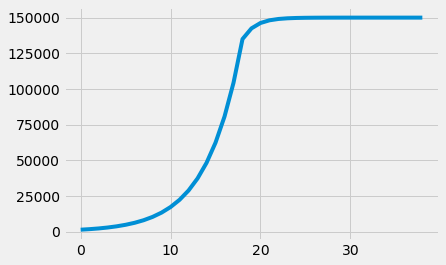

In [11]:
line,coefs = return_polyfit(np.array([X1,X2]),np.array([Y1,Y2]),degree)
max_daily_tests = 150*1e+3
Ys = np.power(test_base,np.arange(19))*A_factor
end_ys = decay_to_max(max_daily_tests,Ys[-1],20)

projected_tests = np.concatenate([Ys,end_ys])
plt.plot(projected_tests)

# USA projections

## Initial assumptions

In [12]:
population = 5
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 9 # of cycles since to Jan 24 to March 16
R0_reduction = 0.9
base_R0 = 0.90
hospital_days = 14
daily_traveler_cases = 50

adv_params = {
        'population':population,
        'R0':R0,
        'asymptomatic_period':asymptomatic_period,
        'hospitalization_rate':hospitalization_rate,
        'inflection_point':inflection_point,
        'R0_reduction':R0_reduction,
        'base_R0':base_R0,
        'hospital_days': hospital_days,
        'tests':projected_tests,
        'pos_rate':0.14,
        'traveler_cases':daily_traveler_cases,
        'print':False
         }

# Generate predictions

In [13]:
advGenerator = advanced_projector(adv_params)
advcurve_data = []
for _ in range(16):
    advcurve_data.append(next(advGenerator))

In [23]:
projection_data = unwrap_projections(advcurve_data)

9


In [187]:
projection_labels = ('day','current_infections','total_infections','hospitalized_patients','R0','daily_confirmed','total_confirmed','daily_tests','total_tests')
projection_combined = {projection_labels[i]:projection_data[i] for i in range(len(projection_labels))}
desired_projection_labels = ['current_infections','hospitalized_patients','daily_confirmed','daily_tests']


# Interpolate between 5 day increments for projected values

In [188]:
def interpolate_projections(projections):
    degree = 2
    length = 3
    day_interval = 5
    interpolated = []
    for i in range(len(projections)-length):
        x = np.arange(i,i+length)
        y = projections[i:i+length]
        line,coefs = return_polyfit(x,y,degree)
        days = np.linspace(i,i+length,day_interval*length)
#         print(days)
        new_ys = poly.polyval(days, coefs)
        if i == len(projections)-4:
            interpolated.append(new_ys)
        else:
            interpolated.append(new_ys[:5])
    return np.hstack(interpolated)
    
def fill_in_projections(projections,labels):
    for label in labels:
        projections[label] = interpolate_projections(projections[label])
    return projections

In [189]:

R0_mask = np.where(np.array(projection_combined['R0']) < 2.3)[0]
end_index = np.min(R0_mask)
R0_part1 = np.full(end_index*5,2.3)
R0_part2 = interpolate_projections(projection_combined['R0'][end_index:])
new_R0 = np.concatenate([R0_part1,R0_part2])
projection_combined['R0'] = new_R0

In [190]:
interpolate_labels = ['current_infections','total_infections','hospitalized_patients','daily_confirmed','total_confirmed','daily_tests','total_tests']
projection_combined = fill_in_projections(projection_combined,interpolate_labels)
projection_combined['day'] = np.arange(projection_combined['total_infections'].shape[0])

In [201]:

keys = projection_combined.keys()
for key in keys:
    print(projection_combined[key].shape)

(75,)
(75,)
(75,)
(75,)
(75,)
(75,)
(75,)
(75,)
(75,)


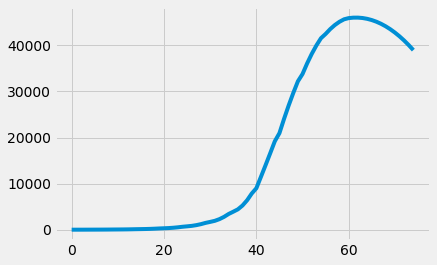

In [193]:
plt.plot(projection_combined['current_infections'])

In [206]:
covidtracking_USA_df['date']

0     20200304
1     20200305
2     20200306
3     20200307
4     20200308
5     20200309
6     20200310
7     20200311
8     20200312
9     20200313
10    20200314
11    20200315
12    20200316
13    20200317
14    20200318
15    20200319
16    20200320
17    20200321
18    20200322
19    20200323
Name: date, dtype: int64

# US values

In [209]:
padding = np.full(44,0)

In [210]:
US_positive = np.concatenate([padding,covidtracking_USA_df['positive']])
US_negative = np.concatenate([padding,covidtracking_USA_df['negative']])
US_tests = np.concatenate([padding,covidtracking_USA_df['posNeg']])
US_hospitalized = np.concatenate([padding,covidtracking_USA_df['hospitalized']])
US_deaths = np.concatenate([padding,covidtracking_USA_df['death']])

In [15]:
US_cases = US.iloc[:,4:]
US_totals = US_cases.sum(axis=0).values

In [207]:
US_actual_start = datetime.datetime(2020,1,20)
data_start_date = datetime.datetime(2020,3,4)
print(f'Duration since first case {datetime.datetime.now() - US_actual_start}')
print(f'Duration from first case to data start {data_start_date - US_actual_start}')

Duration since first case 63 days, 18:40:24.478972
Duration from first case to data start 44 days, 0:00:00


In [203]:
US_deaths.shape[0]

20

# Plot real values vs projected

In [211]:
values = [np.gradient(US_positive),US_positive
          ,np.gradient(US_negative),US_negative,
          np.gradient(US_tests),US_tests,
          np.gradient(US_hospitalized),US_hospitalized,
          np.gradient(US_deaths),US_deaths]
labels = ['daily_confirmed','total_confirmed',
          'daily_negative','total_negative',
          'daily_tests','total_tests',
          'daily_hospitalizations','total_hospitalizations',
          'daily_deaths','total_deaths']
us_combined = {labels[i]:values[i] for i in range(len(values))}
desired_labels = ['daily_confirmed','daily_tests','daily_hospitalizations']

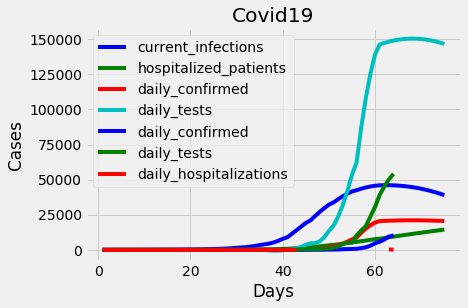

In [212]:
detailed_plot(projection_combined,desired_projection_labels)

detailed_plot(us_combined,desired_labels)

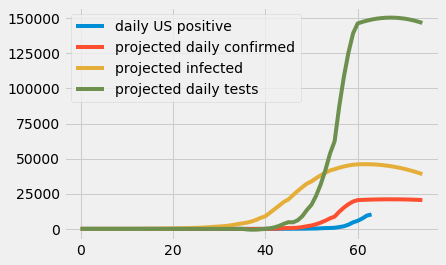

In [216]:
plt.plot(np.gradient(US_positive),label='daily US positive')
plt.plot(projection_combined['daily_confirmed'],label='projected daily confirmed')
plt.plot(projection_combined['current_infections'],label='projected infected')
plt.plot(projection_combined['daily_tests'],label='projected daily tests')
plt.legend()

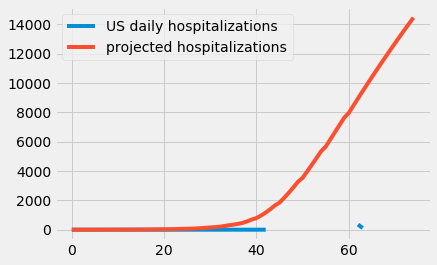

In [214]:
plt.plot(us_combined['daily_hospitalizations'],label='US daily hospitalizations')
plt.plot(projection_combined['hospitalized_patients'],label='projected hospitalizations')
plt.legend()

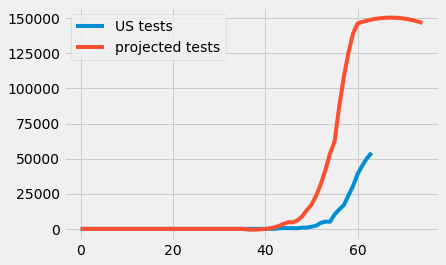

In [215]:
plt.plot(us_combined['daily_tests'],label='US tests')
plt.plot(projection_combined['daily_tests'],label='projected tests')
plt.legend()

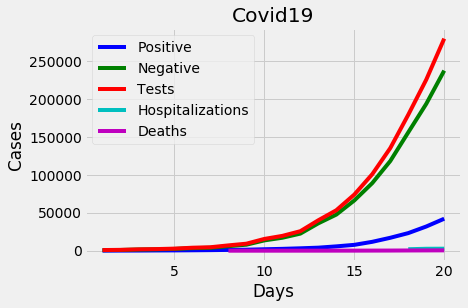

In [18]:
values = [US_positive,US_negative,US_tests,US_hospitalized,US_deaths]
labels = ['Positive','Negative','Tests','Hospitalizations','Deaths']
detailed_plot(values,labels)

# Italy

In [19]:
italy_cases = Italy.iloc[:,4:]
italy_totals = italy_cases.values[0]

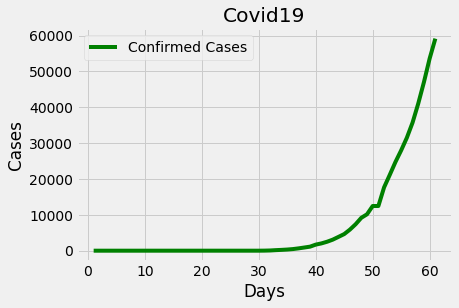

In [20]:
plot_totals(italy_totals)

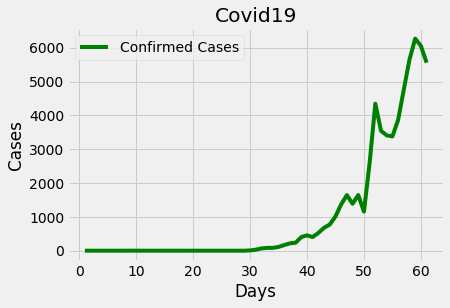

In [21]:
plot_totals(np.gradient(italy_totals))

In [22]:
peak_italy_index = np.argmax(np.gradient(italy_totals))
print(f'Peak index {peak_italy_index}')
print(f'Confirmed cases {italy_totals[peak_italy_index]}')

italy_first_case_index = np.min(np.nonzero(italy_totals))
italy_start_date = parse_date(Italy.columns[4+italy_first_case_index])
italy_peak_date = parse_date(Italy.columns[4+peak_italy_index])
print(f'Date of first case {italy_start_date}')
print(f'Date of peak {italy_peak_date}')

print(f'Duration until peak {italy_peak_date - italy_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

Peak index 58
Confirmed cases 47021
Date of first case 2020-01-31 00:00:00
Date of peak 2020-03-20 00:00:00
Duration until peak 49 days, 0:00:00
Duration since first case 52 days, 16:47:18.146142
